In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#For plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Library for getting mutual info
from sklearn.feature_selection import mutual_info_regression

# for doing randomized or grid search of best estimation in model parameter
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#for scalling the data
from sklearn.preprocessing import MinMaxScaler

# for calculating all scores
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,roc_auc_score, r2_score

# all different models used here
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# to plot confusion matrix of predicted and Y_test value
from sklearn.metrics import confusion_matrix

#to ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
heart = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/Heart.csv")
heart.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   Age         303 non-null    int64  
 2   Sex         303 non-null    int64  
 3   ChestPain   303 non-null    object 
 4   RestBP      303 non-null    int64  
 5   Chol        303 non-null    int64  
 6   Fbs         303 non-null    int64  
 7   RestECG     303 non-null    int64  
 8   MaxHR       303 non-null    int64  
 9   ExAng       303 non-null    int64  
 10  Oldpeak     303 non-null    float64
 11  Slope       303 non-null    int64  
 12  Ca          299 non-null    float64
 13  Thal        301 non-null    object 
 14  AHD         303 non-null    object 
dtypes: float64(2), int64(10), object(3)
memory usage: 35.6+ KB


In [4]:
heart.shape

(303, 15)

In [5]:
heart.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [6]:
heart[[i for i in heart.columns if heart[i].isnull().sum()>0]].isnull().sum()

Ca      4
Thal    2
dtype: int64

In [7]:
heart.Thal.value_counts()

normal        166
reversable    117
fixed          18
Name: Thal, dtype: int64

In [8]:
heart.Thal = heart.Thal.fillna('normal')
heart.Thal.value_counts()

normal        168
reversable    117
fixed          18
Name: Thal, dtype: int64

In [9]:
heart.Ca.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: Ca, dtype: int64

In [10]:
heart.Ca = heart.Ca.fillna(0.0)
heart.Ca.value_counts()

0.0    180
1.0     65
2.0     38
3.0     20
Name: Ca, dtype: int64

In [11]:
print(heart.ChestPain.unique())
print(heart.Thal.unique())
print(heart.AHD.unique())

['typical' 'asymptomatic' 'nonanginal' 'nontypical']
['fixed' 'normal' 'reversable']
['No' 'Yes']


In [12]:
heart_encoding = pd.get_dummies(heart[['ChestPain', 'Thal', 'AHD']])
heart_final = pd.concat([heart, heart_encoding],1)
heart_final = heart_final.drop(['ChestPain', 'Thal', 'AHD'], axis = 1)
heart_final.head(2)

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,...,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_No,AHD_Yes
0,1,63,1,145,233,1,2,150,0,2.3,...,0.0,0,0,0,1,1,0,0,1,0
1,2,67,1,160,286,0,2,108,1,1.5,...,3.0,1,0,0,0,0,1,0,0,1


In [13]:
heart_final.Sex.value_counts()

1    206
0     97
Name: Sex, dtype: int64

In [14]:
heart_final.Sex[heart_final.AHD_Yes ==1].value_counts()

1    114
0     25
Name: Sex, dtype: int64

In [15]:
pd.crosstab(heart_final.AHD_Yes,heart_final.Sex)

Sex,0,1
AHD_Yes,,
0,72,92
1,25,114


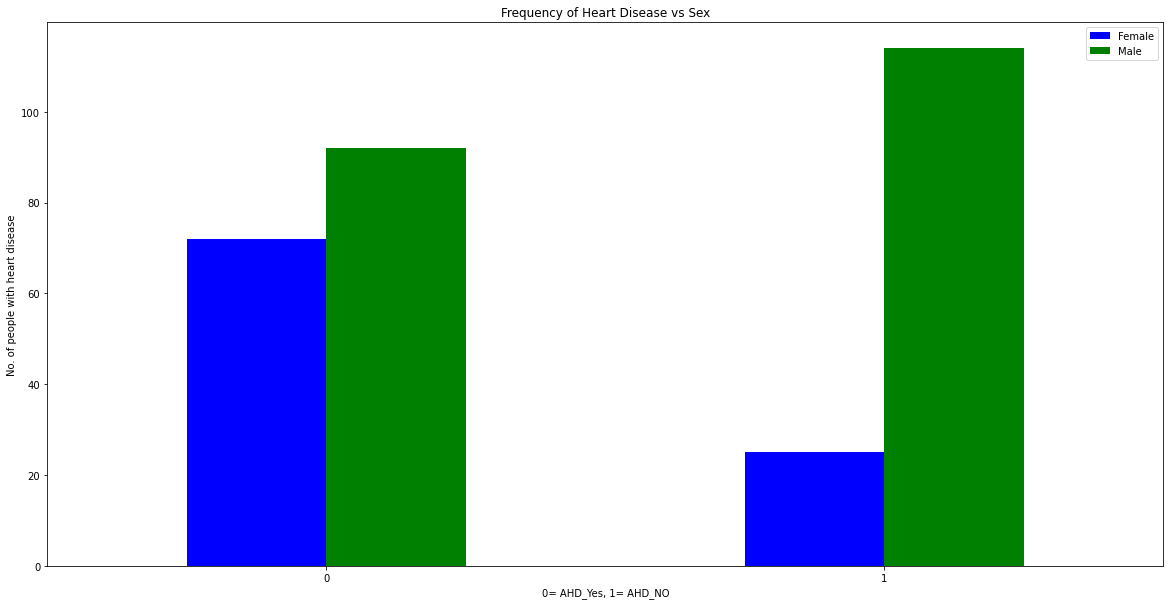

In [16]:
pd.crosstab(heart_final.AHD_Yes,heart_final.Sex).plot(kind='bar',figsize=(20,10),color=["blue","green"])
plt.title("Frequency of Heart Disease vs Sex")
plt.xlabel("0= AHD_Yes, 1= AHD_NO")
plt.ylabel("No. of people with heart disease")
plt.legend(["Female","Male"])
plt.xticks(rotation=0);

Text(0.5, 1.0, 'males vs females with heart disease')

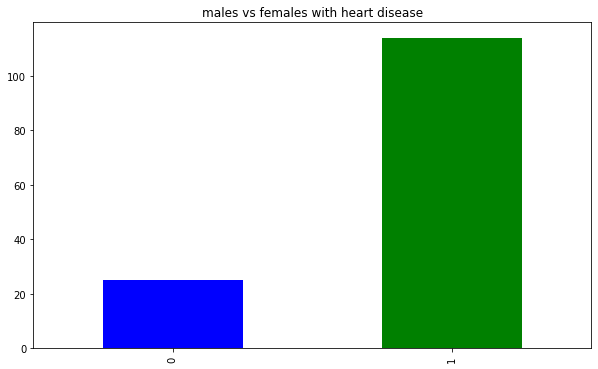

In [17]:
heart_final.Sex[heart_final.AHD_Yes==1].value_counts().plot(kind='bar',figsize=(10,6),color=['green','blue'])
plt.title("males vs females with heart disease")

In [18]:
heart_final.corr()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,...,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_No,AHD_Yes
Unnamed: 0,1.000000,-0.002367,-0.070849,-0.022028,-0.095518,-0.039471,-0.150232,-0.105488,-0.000402,-0.120384,...,0.037011,0.042387,-0.095155,0.069630,-0.015529,0.062412,0.028772,-0.059675,-0.048765,0.048765
Age,-0.002367,1.000000,-0.097542,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,...,0.365323,0.135337,-0.051714,-0.151684,0.045438,0.062042,-0.132264,0.104902,-0.223120,0.223120
Sex,-0.070849,-0.097542,1.000000,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,...,0.086048,0.086398,-0.117189,-0.037990,0.089828,0.142524,-0.387396,0.326284,-0.276816,0.276816
RestBP,-0.022028,0.284946,-0.064456,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,...,0.097528,0.027710,-0.050127,-0.083234,0.149737,0.075157,-0.139782,0.106210,-0.150825,0.150825
Chol,-0.095518,0.208950,-0.199915,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,...,0.123726,0.070343,-0.033223,-0.016453,-0.053021,-0.095743,-0.006479,0.053100,-0.085164,0.085164
Fbs,-0.039471,0.118530,0.047862,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,...,0.140764,-0.062929,0.087027,-0.060649,0.055511,0.091351,-0.073766,0.030953,-0.025264,0.025264
RestECG,-0.150232,0.148868,0.021647,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,...,0.131749,0.122589,-0.089526,-0.102979,0.065581,0.044672,-0.028989,0.007905,-0.169202,0.169202
MaxHR,-0.105488,-0.393806,-0.048663,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,...,-0.265699,-0.371989,0.159876,0.249415,0.079683,-0.159523,0.285812,-0.214326,0.417167,-0.417167
ExAng,-0.000402,0.091661,0.146201,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,...,0.145788,0.464293,-0.266871,-0.233863,-0.093384,0.063073,-0.324082,0.300223,-0.431894,0.431894
Oldpeak,-0.120384,0.203805,0.102173,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,...,0.301067,0.274218,-0.126339,-0.277513,0.086959,0.104635,-0.345731,0.302145,-0.424510,0.424510


In [19]:
heart_final.corr()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,...,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_No,AHD_Yes
Unnamed: 0,1.000000,-0.002367,-0.070849,-0.022028,-0.095518,-0.039471,-0.150232,-0.105488,-0.000402,-0.120384,...,0.037011,0.042387,-0.095155,0.069630,-0.015529,0.062412,0.028772,-0.059675,-0.048765,0.048765
Age,-0.002367,1.000000,-0.097542,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,...,0.365323,0.135337,-0.051714,-0.151684,0.045438,0.062042,-0.132264,0.104902,-0.223120,0.223120
Sex,-0.070849,-0.097542,1.000000,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,...,0.086048,0.086398,-0.117189,-0.037990,0.089828,0.142524,-0.387396,0.326284,-0.276816,0.276816
RestBP,-0.022028,0.284946,-0.064456,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,...,0.097528,0.027710,-0.050127,-0.083234,0.149737,0.075157,-0.139782,0.106210,-0.150825,0.150825
Chol,-0.095518,0.208950,-0.199915,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,...,0.123726,0.070343,-0.033223,-0.016453,-0.053021,-0.095743,-0.006479,0.053100,-0.085164,0.085164
Fbs,-0.039471,0.118530,0.047862,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,...,0.140764,-0.062929,0.087027,-0.060649,0.055511,0.091351,-0.073766,0.030953,-0.025264,0.025264
RestECG,-0.150232,0.148868,0.021647,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,...,0.131749,0.122589,-0.089526,-0.102979,0.065581,0.044672,-0.028989,0.007905,-0.169202,0.169202
MaxHR,-0.105488,-0.393806,-0.048663,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,...,-0.265699,-0.371989,0.159876,0.249415,0.079683,-0.159523,0.285812,-0.214326,0.417167,-0.417167
ExAng,-0.000402,0.091661,0.146201,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,...,0.145788,0.464293,-0.266871,-0.233863,-0.093384,0.063073,-0.324082,0.300223,-0.431894,0.431894
Oldpeak,-0.120384,0.203805,0.102173,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,...,0.301067,0.274218,-0.126339,-0.277513,0.086959,0.104635,-0.345731,0.302145,-0.424510,0.424510


In [20]:
heart_final.corr()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,...,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_No,AHD_Yes
Unnamed: 0,1.000000,-0.002367,-0.070849,-0.022028,-0.095518,-0.039471,-0.150232,-0.105488,-0.000402,-0.120384,...,0.037011,0.042387,-0.095155,0.069630,-0.015529,0.062412,0.028772,-0.059675,-0.048765,0.048765
Age,-0.002367,1.000000,-0.097542,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,...,0.365323,0.135337,-0.051714,-0.151684,0.045438,0.062042,-0.132264,0.104902,-0.223120,0.223120
Sex,-0.070849,-0.097542,1.000000,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,...,0.086048,0.086398,-0.117189,-0.037990,0.089828,0.142524,-0.387396,0.326284,-0.276816,0.276816
RestBP,-0.022028,0.284946,-0.064456,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,...,0.097528,0.027710,-0.050127,-0.083234,0.149737,0.075157,-0.139782,0.106210,-0.150825,0.150825
Chol,-0.095518,0.208950,-0.199915,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,...,0.123726,0.070343,-0.033223,-0.016453,-0.053021,-0.095743,-0.006479,0.053100,-0.085164,0.085164
Fbs,-0.039471,0.118530,0.047862,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,...,0.140764,-0.062929,0.087027,-0.060649,0.055511,0.091351,-0.073766,0.030953,-0.025264,0.025264
RestECG,-0.150232,0.148868,0.021647,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,...,0.131749,0.122589,-0.089526,-0.102979,0.065581,0.044672,-0.028989,0.007905,-0.169202,0.169202
MaxHR,-0.105488,-0.393806,-0.048663,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,...,-0.265699,-0.371989,0.159876,0.249415,0.079683,-0.159523,0.285812,-0.214326,0.417167,-0.417167
ExAng,-0.000402,0.091661,0.146201,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,...,0.145788,0.464293,-0.266871,-0.233863,-0.093384,0.063073,-0.324082,0.300223,-0.431894,0.431894
Oldpeak,-0.120384,0.203805,0.102173,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,...,0.301067,0.274218,-0.126339,-0.277513,0.086959,0.104635,-0.345731,0.302145,-0.424510,0.424510


<AxesSubplot:>

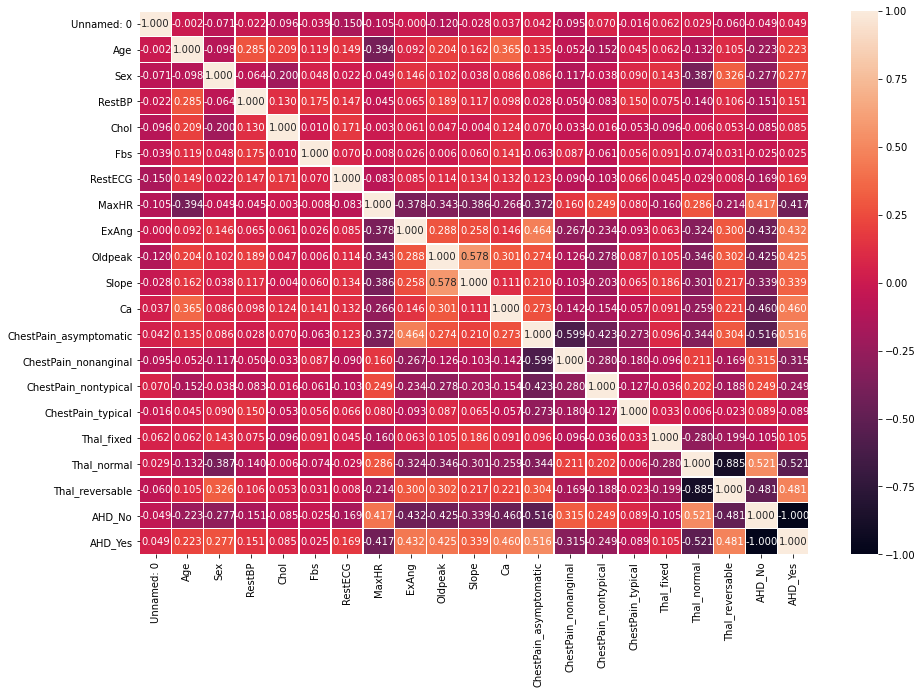

In [21]:
cor_mat=heart_final.corr()
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt=".3f")

In [22]:
heart_final = heart_final.drop(['AHD_No', 'Unnamed: 0'], axis = 1)
heart_final.head(2)

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_Yes
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,1,1,0,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,0,0,0,0,1,0,1


In [23]:
heart_final.columns

Index(['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'ChestPain_asymptomatic',
       'ChestPain_nonanginal', 'ChestPain_nontypical', 'ChestPain_typical',
       'Thal_fixed', 'Thal_normal', 'Thal_reversable', 'AHD_Yes'],
      dtype='object')

In [24]:
heart_scaled = heart_final

In [25]:
MMscal=MinMaxScaler()
features=['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'ChestPain_asymptomatic',
       'ChestPain_nonanginal', 'ChestPain_nontypical', 'ChestPain_typical',
       'Thal_fixed', 'Thal_normal', 'Thal_reversable']
heart_scaled[features] = MMscal.fit_transform(heart_final[features])
heart_scaled.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_Yes
0,0.708333,1.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,0.791667,1.0,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.791667,1.0,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.166667,1.0,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,0.250000,0.0,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


In [26]:
X = heart_scaled.drop('AHD_Yes', axis=1)
Y = heart_scaled.AHD_Yes
#splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2 ,random_state=1)

In [27]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info

ChestPain_asymptomatic    0.182118
Thal_reversable           0.166717
Thal_normal               0.162789
Slope                     0.093031
MaxHR                     0.076607
Ca                        0.074399
ExAng                     0.071927
ChestPain_nontypical      0.065714
Oldpeak                   0.058970
RestECG                   0.040346
ChestPain_nonanginal      0.037340
Chol                      0.035370
Fbs                       0.035323
Sex                       0.027901
ChestPain_typical         0.000000
Thal_fixed                0.000000
RestBP                    0.000000
Age                       0.000000
dtype: float64

In [28]:
Req_Columns = list(mutual_info[mutual_info>0].index)
Req_Columns

['ChestPain_asymptomatic',
 'Thal_reversable',
 'Thal_normal',
 'Slope',
 'MaxHR',
 'Ca',
 'ExAng',
 'ChestPain_nontypical',
 'Oldpeak',
 'RestECG',
 'ChestPain_nonanginal',
 'Chol',
 'Fbs',
 'Sex']

In [29]:
X_train_final = X_train[Req_Columns]
X_train_final.head(1)

,ChestPain_asymptomatic,Thal_reversable,Thal_normal,Slope,MaxHR,Ca,ExAng,ChestPain_nontypical,Oldpeak,RestECG,ChestPain_nonanginal,Chol,Fbs,Sex
62,1.0,1.0,0.0,0.5,0.458015,1.0,1.0,0.0,0.354839,1.0,0.0,0.205479,0.0,1.0


In [30]:
X_test_final = X_test[Req_Columns]
X_test_final.head(1)

,ChestPain_asymptomatic,Thal_reversable,Thal_normal,Slope,MaxHR,Ca,ExAng,ChestPain_nontypical,Oldpeak,RestECG,ChestPain_nonanginal,Chol,Fbs,Sex
204,1.0,1.0,0.0,0.0,0.687023,0.0,0.0,0.0,0.0,0.0,0.0,0.194064,0.0,1.0


In [31]:
def evaluation(Y_test,Y_pred):
    acc=accuracy_score(Y_test,Y_pred)
    rcl=recall_score(Y_test,Y_pred)
    f1=f1_score(Y_test,Y_pred)
    auc_score=roc_auc_score(Y_test,Y_pred)
    prec_score=precision_score(Y_test,Y_pred)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

In [32]:
np.random.seed(42)
KNC_model=  KNeighborsClassifier()
KNC_model.fit(X_train_final,y_train)
KNC_model_y_pred=KNC_model.predict(X_test_final)
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score)
evaluation(y_test,KNC_model_y_pred)

R2 Score for predicted value:  6.97
Accuracy on Training set:  83.88
Accuracy on Testing set:  77.05
{'accuracy': 77.05, 'recall': 70.37, 'F1 score': 73.08, 'auc score': 76.36, 'precision': 76.0}


In [33]:
np.random.seed(42)
LR_model=LogisticRegression()
LR_model.fit(X_train_final,y_train)
LR_model_y_pred=LR_model.predict(X_test_final)
LR_model_r2_score=round(r2_score(y_test,LR_model_y_pred)*100,2)
print("R2 Score for predicted value: ",LR_model_r2_score)
print("Accuracy on Training set: ",round(LR_model.score(X_train_final,y_train)*100,2))
LR_model_score = round(LR_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",LR_model_score)
evaluation(y_test,LR_model_y_pred)

R2 Score for predicted value:  26.91
Accuracy on Training set:  84.3
Accuracy on Testing set:  81.97
{'accuracy': 81.97, 'recall': 77.78, 'F1 score': 79.25, 'auc score': 81.54, 'precision': 80.77}


In [34]:
np.random.seed(42)
RFC_model=RandomForestClassifier()
RFC_model.fit(X_train_final,y_train)
RFC_model_y_pred=RFC_model.predict(X_test_final)
RFC_model_r2_score=round(r2_score(y_test,RFC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model.score(X_train_final,y_train)*100,2))
RFC_model_score = round(RFC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",RFC_model_score)
evaluation(y_test,RFC_model_y_pred)

R2 Score for predicted value:  13.62
Accuracy on Training set:  100.0
Accuracy on Testing set:  78.69
{'accuracy': 78.69, 'recall': 74.07, 'F1 score': 75.47, 'auc score': 78.21, 'precision': 76.92}


In [35]:
np.random.seed(42)
SVC_model=SVC()
SVC_model.fit(X_train_final,y_train)
SVC_model_y_pred=SVC_model.predict(X_test_final)
SVC_model_r2_score=round(r2_score(y_test,SVC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model.score(X_train_final,y_train)*100,2))
SVC_model_score = round(SVC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",SVC_model_score)
evaluation(y_test,SVC_model_y_pred)

R2 Score for predicted value:  20.26
Accuracy on Training set:  88.02
Accuracy on Testing set:  80.33
{'accuracy': 80.33, 'recall': 77.78, 'F1 score': 77.78, 'auc score': 80.07, 'precision': 77.78}


In [36]:
XGB_model=XGBClassifier()
XGB_model.fit(X_train_final,y_train)
XGB_model_y_pred=XGB_model.predict(X_test_final)
XGB_model_r2_score=round(r2_score(y_test,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model.score(X_train_final,y_train)*100,2))
XGB_model_score = round(XGB_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",XGB_model_score)
evaluation(y_test,XGB_model_y_pred)

[18:34:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
R2 Score for predicted value:  -6.32
Accuracy on Training set:  100.0
Accuracy on Testing set:  73.77
{'accuracy': 73.77, 'recall': 74.07, 'F1 score': 71.43, 'auc score': 73.8, 'precision': 68.97}


In [37]:
all_model_score = pd.DataFrame({'Model_Name': ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbour', 'Support Vector Machine', "Extreme Gradient Boost"], 
                                'Accuracy_Score': [LR_model_score, RFC_model_score, KNC_model_score, SVC_model_score, XGB_model_score]})
all_model_score = all_model_score.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score

,Model_Name,Accuracy_Score
0,Logistic Regression,81.97
3,Support Vector Machine,80.33
1,Random Forest,78.69
2,K-Nearest Neighbour,77.05
4,Extreme Gradient Boost,73.77


In [38]:
j = range(1, 31) # 1 to 30

# Setup algorithm
knc_model = KNeighborsClassifier()
knc_count=1
score_final = 0
# Loop through different neighbors values
for i in j:
    knc_model.set_params(n_neighbors = i) # set neighbors value
    score = round(knc_model.fit(X_train_final, y_train).score(X_test_final,y_test)*100,2)
    if score > score_final:
        score_final = score
        knc_count = i
    # Fit the algorithm
    #print(f"Accuracy with {i} no. of neighbors: {score}%")
print('Best n_neighbors is: ' + str(knc_count) + ', with accuracy score of ' + str(score_final) +'%')

Best n_neighbors is: 26, with accuracy score of 81.97%


In [39]:
np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier
KNC_model=  KNeighborsClassifier(n_neighbors=knc_count)
KNC_model.fit(X_train_final,y_train)
KNC_model_y_pred=KNC_model.predict(X_test_final)
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score_mannual = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_mannual)
evaluation(y_test,KNC_model_y_pred)

R2 Score for predicted value:  26.91
Accuracy on Training set:  82.64
Accuracy on Testing set:  81.97
{'accuracy': 81.97, 'recall': 74.07, 'F1 score': 78.43, 'auc score': 81.15, 'precision': 83.33}


In [40]:
knn_param_grid={'n_neighbors': np.arange(1,31,1),
          'leaf_size': np.arange(1,31,1)}

knn_gs_model=GridSearchCV(KNeighborsClassifier(),param_grid=knn_param_grid,cv=5,verbose=True)

knn_gs_model.fit(X_train_final, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             verbose=True)

In [41]:
knn_gs_model.best_params_

{'leaf_size': 1, 'n_neighbors': 29}

In [42]:
best_results = pd.DataFrame(knn_gs_model.best_params_, index=[0])
best_results

,leaf_size,n_neighbors
0,1,29


In [43]:
np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier
KNC_model=  KNeighborsClassifier(n_neighbors=best_results.n_neighbors[0], leaf_size = best_results.leaf_size[0] )
KNC_model.fit(X_train_final,y_train)
KNC_model_y_pred=KNC_model.predict(X_test_final)
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score_gs = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_gs)
evaluation(y_test,KNC_model_y_pred)

R2 Score for predicted value:  26.91
Accuracy on Training set:  83.06
Accuracy on Testing set:  81.97
{'accuracy': 81.97, 'recall': 77.78, 'F1 score': 79.25, 'auc score': 81.54, 'precision': 80.77}


In [44]:
KNC_model_score2 =max(KNC_model_score_gs, KNC_model_score_mannual)
KNC_model_score2

81.97

In [45]:
np.random.seed(42)
rf_count=1
score_final = 0
rfc_model = RandomForestClassifier()
#checked once till 50, still found the best estimator at 7, so decresed the range to 10 for future runs
for i in range(1,10,1):
    #print(f"With {i} estimators:")
    rfc_model=rfc_model.set_params(n_estimators=i*10,max_depth=i,random_state=i)
    score = round(rfc_model.fit(X_train_final, y_train).score(X_test_final,y_test)*100,2)
    if score > score_final:
        score_final = score
        rf_count = i*10
    #print(f"Accuracy: {clf2.score(X_test_final,y_test)*100:2f}%")
print('Best n_estimators is: ' + str(rf_count) + ', with accuracy score of ' + str(score_final) +'%')

Best n_estimators is: 50, with accuracy score of 83.61%


In [46]:
np.random.seed(42)
RFC_model=RandomForestClassifier(n_estimators=rf_count, max_depth=(rf_count/10),random_state=int(rf_count/10))
RFC_model.fit(X_train_final,y_train)
RFC_model_y_pred=RFC_model.predict(X_test_final)
RFC_model_r2_score=round(r2_score(y_test,RFC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model.score(X_train_final,y_train)*100,2))
RFC_model_score2 = round(RFC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",RFC_model_score2)
evaluation(y_test,RFC_model_y_pred)

R2 Score for predicted value:  33.55
Accuracy on Training set:  92.56
Accuracy on Testing set:  83.61
{'accuracy': 83.61, 'recall': 77.78, 'F1 score': 80.77, 'auc score': 83.01, 'precision': 84.0}


In [47]:
learning_rate = [0.01, 0.1]
max_depth = [int(x) for x in np.linspace(5, 40, num = 6)]
min_child_weight = [int(x) for x in np.linspace(1, 20, num = 6)]
subsample =  [0.5, 0.7]
colsample_bytree = [0.5, 0.7]
objective = ['reg:squarederror']
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 40)]
gamma = [0.6, 0.7]
seed = [27]
reg_lambda = [2]
booster = ['dart']
colsample_bylevel = [0.6]
colsample_bynode = [0.5]

random_grid_param = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'objective': objective,
               'n_estimators': n_estimators,
               'gamma': gamma,
               'seed' : seed,
               'reg_lambda' : reg_lambda,
               'booster' : booster,
               'colsample_bylevel' : colsample_bylevel,
               'colsample_bynode' : colsample_bynode}


XGB_rg_model = RandomizedSearchCV(estimator = XGB_model, param_distributions = random_grid_param,scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

XGB_rg_model.fit(X_train_final,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END booster=dart, colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.6, learning_rate=0.1, max_depth=19, min_child_weight=20, n_estimators=883, objective=reg:squarederror, reg_lambda=2, seed=27, subsample=0.7; total time=   0.5s
[CV] END booster=dart, colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.6, learning_rate=0.1, max_depth=19, min_child_weight=20, n_estimators=883, objective=reg:squarederror, reg_lambda=2, seed=27, subsample=0.7; total time=   0.5s
[CV] END booster=dart, colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.6, learning_rate=0.1, max_depth=19, min_child_weight=20, n_estimators=883, objective=reg:squarederror, reg_lambda=2, seed=27, subsample=0.7; total time=   0.5s
[CV] END booster=dart, colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.6, learning_rate=0.1, max_depth=19, min_child_weight=20, n_estimato

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=4,
                                           num_pa...
                                        'max_depth': [5, 12, 19, 26, 33, 40],
                                        'min_child_weight'

In [48]:
best_results_XGB = pd.DataFrame(XGB_rg_model.best_params_, index=[0])
best_results_XGB

,subsample,seed,reg_lambda,objective,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,colsample_bynode,colsample_bylevel,booster
0,0.5,27,2,reg:squarederror,1543,16,12,0.01,0.6,0.5,0.5,0.6,dart


In [49]:
XGB_model=XGBClassifier(subsample= best_results_XGB.subsample[0], 
                        seed= best_results_XGB.seed[0], 
                        reg_lambda= best_results_XGB.reg_lambda[0],
                        objective= best_results_XGB.objective[0],
                        n_estimators= best_results_XGB.n_estimators[0],
                        min_child_weight= best_results_XGB.min_child_weight[0],
                        max_depth= best_results_XGB.max_depth[0],
                        learning_rate= best_results_XGB.learning_rate[0],
                        gamma= best_results_XGB.gamma[0],
                        colsample_bytree= best_results_XGB.colsample_bytree[0],
                        colsample_bynode= best_results_XGB.colsample_bynode[0],
                        colsample_bylevel= best_results_XGB.colsample_bylevel[0],
                        booster= best_results_XGB.booster[0])

XGB_model.fit(X_train_final,y_train)
XGB_model_y_pred=XGB_model.predict(X_test_final)
XGB_model_r2_score=round(r2_score(y_test,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model.score(X_train_final,y_train)*100,2))
XGB_model_score2 = round(XGB_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",XGB_model_score2)

R2 Score for predicted value:  40.2
Accuracy on Training set:  87.19
Accuracy on Testing set:  85.25


In [50]:

param_grid = {'C': [0.1, 1,2, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}  
  
svc_gs_model = GridSearchCV(SVC(), param_grid,cv=5, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svc_gs_model.fit(X_train_final, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ...................C=0.1, gamma=0.

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 2, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [51]:
best_results_SVC = pd.DataFrame(svc_gs_model.best_params_, index=[0])
best_results_SVC

,C,gamma,kernel
0,1000,1,linear


In [52]:
np.random.seed(42)
SVC_model=SVC(C= best_results_SVC.C[0], gamma= best_results_SVC.gamma[0], kernel= best_results_SVC.kernel[0])
SVC_model.fit(X_train_final,y_train)
SVC_model_y_pred=SVC_model.predict(X_test_final)
SVC_model_r2_score=round(r2_score(y_test,SVC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model.score(X_train_final,y_train)*100,2))
SVC_model_score2 = round(SVC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",SVC_model_score2)
evaluation(y_test,SVC_model_y_pred)

R2 Score for predicted value:  20.26
Accuracy on Training set:  87.6
Accuracy on Testing set:  80.33
{'accuracy': 80.33, 'recall': 74.07, 'F1 score': 76.92, 'auc score': 79.68, 'precision': 80.0}


In [53]:
all_model_score_tunned = pd.DataFrame({'Model_Name': ['Logistic Regression', 'Random Forest_Tunned', 'K-Nearest Neighbour_Tunned', 
                                                      'Support Vector Machine_Tunned',"Extreme Gradient Boost_Tunned"], 
                                'Accuracy_Score': [LR_model_score, RFC_model_score2, KNC_model_score2, SVC_model_score2, XGB_model_score2]})
all_model_score_tunned = all_model_score_tunned.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_tunned

,Model_Name,Accuracy_Score
4,Extreme Gradient Boost_Tunned,85.25
1,Random Forest_Tunned,83.61
0,Logistic Regression,81.97
2,K-Nearest Neighbour_Tunned,81.97
3,Support Vector Machine_Tunned,80.33


In [54]:
all_model_score

,Model_Name,Accuracy_Score
0,Logistic Regression,81.97
3,Support Vector Machine,80.33
1,Random Forest,78.69
2,K-Nearest Neighbour,77.05
4,Extreme Gradient Boost,73.77


In [55]:
all_model_score_final = pd.concat([all_model_score_tunned, all_model_score],0)
all_model_score_final = all_model_score_final.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_final

,Model_Name,Accuracy_Score
4,Extreme Gradient Boost_Tunned,85.25
1,Random Forest_Tunned,83.61
0,Logistic Regression,81.97
2,K-Nearest Neighbour_Tunned,81.97
0,Logistic Regression,81.97
3,Support Vector Machine_Tunned,80.33
3,Support Vector Machine,80.33
1,Random Forest,78.69
2,K-Nearest Neighbour,77.05
4,Extreme Gradient Boost,73.77


In [56]:
all_model_score_final = all_model_score_final.drop_duplicates()
all_model_score_final

,Model_Name,Accuracy_Score
4,Extreme Gradient Boost_Tunned,85.25
1,Random Forest_Tunned,83.61
0,Logistic Regression,81.97
2,K-Nearest Neighbour_Tunned,81.97
3,Support Vector Machine_Tunned,80.33
3,Support Vector Machine,80.33
1,Random Forest,78.69
2,K-Nearest Neighbour,77.05
4,Extreme Gradient Boost,73.77


In [57]:
print("Best evaluation parameters achieved with Random Forest and XGBoost model:")
print("Evaluation parameters achieved with Random Forest:")
evaluation(y_test,RFC_model_y_pred)
print("Evaluation parameters achieved with XGBoost model:")
evaluation(y_test,XGB_model_y_pred)

Best evaluation parameters achieved with Random Forest and XGBoost model:
Evaluation parameters achieved with Random Forest:
{'accuracy': 83.61, 'recall': 77.78, 'F1 score': 80.77, 'auc score': 83.01, 'precision': 84.0}
Evaluation parameters achieved with XGBoost model:
{'accuracy': 85.25, 'recall': 77.78, 'F1 score': 82.35, 'auc score': 84.48, 'precision': 87.5}


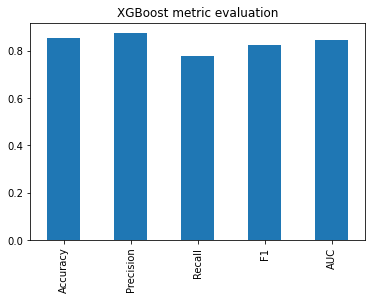

In [58]:
XGB_final_metrics={'Accuracy': XGB_model.score(X_test_final,y_test),
                   'Precision': precision_score(y_test,XGB_model_y_pred),
                   'Recall': recall_score(y_test,XGB_model_y_pred),
                   'F1': f1_score(y_test,XGB_model_y_pred),
                   'AUC': roc_auc_score(y_test,XGB_model_y_pred)}

XGB_metrics=pd.DataFrame(XGB_final_metrics,index=[0])
XGB_metrics.T.plot.bar(title='XGBoost metric evaluation',legend=False);

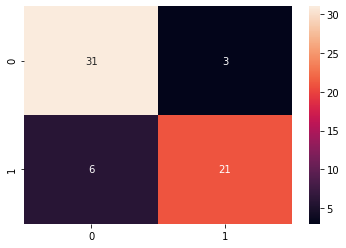

In [59]:
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,XGB_model_y_pred),annot=True,cbar=True)

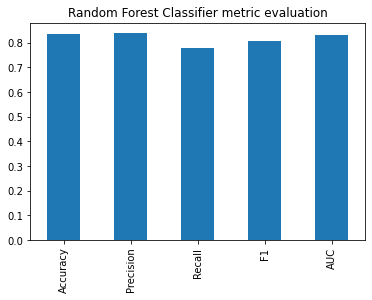

In [60]:
RFC_final_metrics={'Accuracy': RFC_model.score(X_test_final,y_test),
                   'Precision': precision_score(y_test,RFC_model_y_pred),
                   'Recall': recall_score(y_test,RFC_model_y_pred),
                   'F1': f1_score(y_test,RFC_model_y_pred),
                   'AUC': roc_auc_score(y_test,RFC_model_y_pred)}

RFC_metrics=pd.DataFrame(RFC_final_metrics,index=[0])
RFC_metrics.T.plot.bar(title='Random Forest Classifier metric evaluation',legend=False);

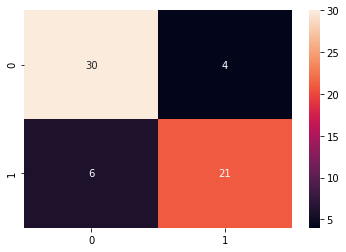

In [61]:
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,RFC_model_y_pred),annot=True,cbar=True)